# 1. pib

## Variables

- consumo_privado
- inversiones
- gasto_publico
- exportaciones
- importaciones
- variacion


In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from functools import partial

cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')

## Importación de datos

In [2]:
input_files = {'consumo_privado': ['sector_real', 'pib_gasto', 'gasto_consumo_final_hogar_isflsh.csv'],
         'inversiones': ['sector_real', 'pib_gasto', 'formacion_bruta_capital_fijo.csv'],
          'gasto_publico': ['sector_real', 'pib_gasto', 'gasto_consumo_final_gobierno_central.csv'],
         'exportaciones': ['sector_real', 'pib_gasto', 'exportacion_bienes_servicios.csv'],
         'importaciones': ['sector_real', 'pib_gasto', 'importaciones_bienes_servicios.csv'],
         'variacion' : ['sector_real', 'pib_gasto', 'variacion_existencias.csv'],
             'pib': ['sector_real', 'pib', 'pib.csv']}

input_list = []
for name, path in input_files.items():
  file_path = os.path.join(input_path, *path)
  df_input = (pd
                .read_csv(file_path, sep=',')
                .rename(columns={'Fecha': 'fa', 'Valor': name})
                .assign(fa = lambda df: pd.to_datetime(df['fa'], dayfirst=True))
                .set_index('fa')
                )
  input_list.append(df_input)

df = pd.concat(input_list, axis=1, join='outer')
output_filepath = os.path.join(output_path, 'pib_dataset.xlsx')
df.to_excel(output_filepath)

In [3]:
df

,consumo_privado,inversiones,gasto_publico,exportaciones,importaciones,variacion,pib
fa,,,,,,,
2009-06-30,7645.80,12386.80,66165.10,17180.50,22876.00,-5504.40,74997.80
2009-09-30,8728.90,11359.10,65711.90,16196.50,25296.90,-31.90,76667.60
2009-12-31,9664.60,12432.40,67381.60,18393.60,27584.60,-220.70,80066.90
2010-03-31,7904.40,12062.50,69048.80,20262.00,26222.30,708.70,83764.10
2010-06-30,8587.80,12647.00,70970.00,20276.90,28017.00,-3518.40,80946.30
...,...,...,...,...,...,...,...
2023-06-30,23129.23,31663.98,175761.43,34678.17,64363.65,-21.74,200847.42
2023-09-30,23189.90,34766.21,179216.82,33039.01,66146.42,-367.91,203697.61
2023-12-31,24929.79,34067.36,187342.98,31587.40,66394.61,1163.69,212696.62


## Procesamiento

In [6]:
def data_processing(df, target_var, t_samples, keep_all):
    df_shifted = df[[target_var]].copy()
    for n in range(1, t_samples + 1):
        for col in df.columns:
            df_shifted[f'{col}_t_{n}'] = df[col].shift(n)
    df_shifted = df_shifted.dropna()

    for col in df.columns:
        df_shifted[f'{col}_prom_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].mean(axis=1)
        df_shifted[f'{col}_desv_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].std(axis=1)
        df_shifted[f'{col}_min_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].min(axis=1)
        df_shifted[f'{col}_max_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].max(axis=1)
        df_shifted[f'{col}_sum_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].sum(axis=1)

    if not keep_all:
        columns_to_keep = [target_var] + [f'{col}_t_{1}' for col in df.columns] + \
                          [f'{col}_{agg}_{t_samples}' for col in df.columns for agg in ['prom', 'desv', 'min', 'max', 'sum']]
        df_shifted = df_shifted[columns_to_keep]

    return df_shifted

target_var = 'pib'
df_shifted = data_processing(df, target_var, 4, False)

X = df_shifted.drop(columns=[target_var])
y = df_shifted[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Entrenamiento

In [39]:
def arquitectura_ann(cant_capas, cant_neurons, input_dim):
    model = Sequential([Input(shape=(input_dim,))])
    for _ in range(cant_capas):
        model.add(Dense(cant_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def optimizar_ann(trial, X_train, y_train, X_test, y_test):
    cant_capas = trial.suggest_int('cant_capas', 2, 5)
    cant_neurons = trial.suggest_int('cant_neurons', 50, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    model = arquitectura_ann(cant_capas, cant_neurons, X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test),
        epochs=100, batch_size=batch_size, verbose=0, callbacks=[early_stopping]
    )
    return min(history.history['val_loss'])

In [40]:
def train_models(X_train, X_test, y_train, y_test):
    best_models = {}

    model_ar = ARIMA(y_train.asfreq('QE'), order=(1, 0, 0), exog=X_train.asfreq('QE')).fit()
    best_models['ar'] = model_ar
    model_arima = ARIMA(y_train.asfreq('QE'), order=(1, 0, 1), exog=X_train.asfreq('QE')).fit()
    best_models['arima'] = model_arima

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    best_models['lr'] = model_lr

    params_knn = {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance']}
    grid_knn = GridSearchCV(KNeighborsRegressor(), params_knn, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_knn.fit(X_train, y_train)
    best_models['knn'] = grid_knn.best_estimator_
    print(f"KNN Best Parameters: {grid_knn.best_params_}")

    params_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    grid_rf = GridSearchCV(RandomForestRegressor(), params_rf, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_rf.fit(X_train, y_train)
    best_models['rf'] = grid_rf.best_estimator_
    print(f"Random Forest Best Parameters: {grid_rf.best_params_}")

    model_xgb = xgb.XGBRegressor()
    model_xgb.fit(X_train, y_train)
    best_models['xgb'] = model_xgb

    study = optuna.create_study(direction='minimize')
    study.optimize(partial(optimizar_ann, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test), n_trials=50)

    best_params = study.best_params
    print(f"ANN Best Parameters: {best_params}")

    model_ann = arquitectura_ann(best_params['cant_capas'], best_params['cant_neurons'], X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_ann.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test),
        epochs=100, batch_size=best_params['batch_size'], verbose=1, callbacks=[early_stopping]
    )

    model_ann.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model_ann.fit(X_train, y_train, epochs=100, verbose=0)
    best_models['ann'] = model_ann

    return best_models

best_models = train_models(X_train, X_test, y_train, y_test)

/Users/damoib/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[I 2024-11-16 14:50:38,596] A new study created in memory with name: no-name-26a83c42-a637-4114-8ed2-ea4f02974340


Random Forest Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


2024-11-16 14:50:39.011049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
[I 2024-11-16 14:50:40,010] Trial 0 finished with value: 57295872.0 and parameters: {'cant_capas': 5, 'cant_neurons': 56, 'batch_size': 128}. Best is trial 0 with value: 57295872.0.
[I 2024-11-16 14:50:41,458] Trial 1 finished with value: 8111421.5 and parameters: {'cant_capas': 3, 'cant_neurons': 97, 'batch_size': 32}. Best is trial 1 with value: 8111421.5.
[I 2024-11-16 14:50:43,101] Trial 2 finished with value: 23709018.0 and parameters: {'cant_capas': 5, 'cant_neurons': 95, 'batch_size': 16}. Best is trial 1 with value: 8111421.5.
[I 2024-11-16 14:50:45,149] Trial 3 finished with value: 33172922.0 and parameters: {'cant_capas': 5, 'cant_neurons': 99, 'batch_size': 64}. Best is trial 1 with value: 8111421.5.
[I 2024-11-16 14:50:46,071] Trial 4 finished with value: 136095408.0 and parameters: {'cant_capas': 2

ANN Best Parameters: {'cant_capas': 4, 'cant_neurons': 73, 'batch_size': 32}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 15205289984.0000 - val_loss: 17142964224.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6143760896.0000 - val_loss: 4076109824.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1415024640.0000 - val_loss: 78664584.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 71574920.0000 - val_loss: 1457522688.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 710887168.0000 - val_loss: 3001874432.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1262582144.0000 - val_loss: 1760401024.0000
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 728955584.0000 - val_loss: 280755168.0000
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 134631840.0000 - val_loss: 93151872.0000


## Evaluación

In [41]:
def evaluate(best_models, X_test, y_test):
    results = {}
    for name, model in best_models.items():
        if name in ('ar','arima'):
            y_pred = model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
        else:
            y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results[name] = {'y_pred' : y_pred,
                         'mse' : mse}
        print(f"{name}: {mse=:,.2f}")
        
    return results
results = evaluate(best_models, X_test, y_test)

ar: mse=922,132,789.75
arima: mse=897,089,161.17
lr: mse=897,404,738.89
knn: mse=2,196,716,408.92
rf: mse=1,972,656,968.87
xgb: mse=1,583,632,262.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
ann: mse=17,223,602.16


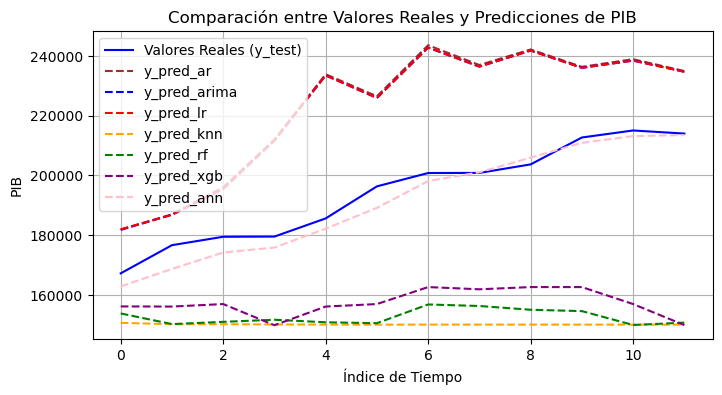

In [42]:
def plot_comparison(results):
    colors = {'ar' : 'brown',
              'arima' : 'blue',
              'lr' : 'red',
              'knn' : 'orange',
              'rf' : 'green',
              'xgb' : 'purple',
              'ann' : 'pink'}
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.values, label="Valores Reales (y_test)", color="blue")
    
    for name, result in results.items():
        if name in ('ar', 'arima'):
            plt.plot(result['y_pred'].reset_index(drop=True), label=f"y_pred_{name}", color=colors[name], linestyle="--")
        else:
            plt.plot(result['y_pred'], label=f"y_pred_{name}", color=colors[name], linestyle="--")

    plt.xlabel("Índice de Tiempo")
    plt.ylabel("PIB")
    plt.title("Comparación entre Valores Reales y Predicciones de PIB")
    plt.legend()
    plt.grid()
    plt.savefig('image.png', dpi=300)
    plt.show()

plot_comparison(results)